# Synthetic Tree with Random Branch $b\in [1,10]$

In [26]:
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
type = "random"
final_level = 4

In [28]:
import os
import pickle
import pandas as pd
import numpy as np
import tqdm as tqdm
from IPython.display import clear_output
from metrics import analysis
import argparse
from data_structure import GeoSpine
from data_structure import OD_tree
import time
import os
import matplotlib.pyplot as plt

# Functions

In [29]:
mechanisms = ["SH", "VanillaGauss", r"$\text{GaussOpt}-{\ell_2}$", r"$\text{GaussOpt}-{\ell_\infty}$", r"$\text{GaussOpt}-{\ell_\infty}-\text{IntOpt}$"]
markers = [["-s", "-*", "-v", "-8", "-P"], ["--s", "--*", "--v", "--8", "--P"]]
colors = plt.cm.viridis(np.linspace(0, 1, len(mechanisms)))  # Generate distinct colors

In [30]:
epsilons = [1., 10.]
delta = 1E-8
num_experiments = 10

# mechanisms, epsilons, experiments, levels
num_mechanisms = 5

In [31]:
def apply_mechanism(Tree: OD_tree, metrics: dict, mech: callable, args: argparse.Namespace, num_mech: int, num_eps: int):
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        start = time.time()
        data = mech(Tree, args)
        end = time.time()
        metrics["TIME"][num_mech, num_eps, i] = end - start
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data,
                                     spine=Tree.spine,
                                     workload=workload)
            metrics["max_error"][num_mech, e, i, j] = analysis_dict["max_absolute_error"]
            metrics["false_discovery_rate"][num_mech, e, i, j] = analysis_dict["false_discovery_rate"]
            metrics["false_negative_rate"][num_mech, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    metrics["MAE"][num_mech, num_eps] = error_to_add
    metrics["std"][num_mech, num_eps] = std_to_add

In [32]:
def plot(array, save_to: str = None, name: str = None, log: bool = True, y_label: str = None):
    fig, ax = plt.subplots(figsize=(6, 6))
    for i, mechanism in enumerate(mechanisms):
        for j, epsilon in enumerate(epsilons):
            # plot error bar line for each level using min max
            error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                              np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
            ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                        label=mechanism + r" $\varepsilon$: " + str(epsilon),
                        fmt=markers[j][i], color=colors[i])
    if log: ax.set_yscale("log")
    # Setting labels and ticks
    ax.set_ylabel(y_label, fontsize=15)
    ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
    # ax.set_xticks(range(len(levels)))
    # ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
    # augment font size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # Display the plot
    plt.grid(True)
    plt.tight_layout()
    # save a version with no legend
    if save_to is not None and name is not None:
        if os.path.exists(save_to) is False:
            os.makedirs(save_to)
        plt.savefig(os.path.join(save_to, name) + "_nolegend.pdf", dpi=300)
    # Adding a legend
    plt.legend()
    # save
    plt.tight_layout()
    if save_to is not None and name is not None:
        plt.savefig(os.path.join(save_to, name) + ".pdf", dpi=300)
    plt.show()

In [33]:
def MAE_plot(MAE, std, save_to: str = None, name: str = None):
    fig, ax = plt.subplots(figsize=(6, 6))
    for i, mechanism in enumerate(mechanisms):
        for j, epsilon in enumerate(epsilons):
            ax.errorbar(range(len(levels)), MAE[i, j], yerr=std[i, j],
                        label=mechanism + f" eps: {epsilon}",
                        fmt=markers[j][i], color=colors[i], capsize=3)
    ax.set_yscale("log")
    # Setting labels and ticks
    ax.set_ylabel("Absolute Error", fontsize=15)
    ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
    # ax.set_xticks(range(len(levels)))
    # ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
    # augment font size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # Display the plot
    plt.grid(True)
    # save a version with no legend
    if save_to is not None and name is not None:
        if os.path.exists(save_to) is False:
            os.makedirs(save_to)
        plt.savefig(os.path.join(save_to, name) + "_nolegend.pdf", dpi=300)
    # Adding a legend
    plt.legend()
    # save
    plt.tight_layout()
    if save_to is not None and name is not None:
        plt.savefig(os.path.join(save_to, name) + ".pdf", dpi=300)
    plt.show()

In [34]:
def plot_time(execution_times, save_to: str = None, name: str = None):
    # Compute mean, min, and max for each mechanism and epsilon
    mean_times = execution_times.mean(axis=2)
    min_times = execution_times.min(axis=2)
    max_times = execution_times.max(axis=2)
    
    # Compute error bars
    error_bars = [mean_times - min_times, max_times - mean_times]
    
    # Plotting parameters
    colors = plt.cm.viridis(np.linspace(0, 1, len(epsilons)))  # Generate distinct colors
    x_positions = np.arange(len(mechanisms))
    bar_width = 0.3  # Width of each bar
    
    # Plot
    plt.figure(figsize=(8, 6))
    for i, epsilon in enumerate(epsilons):
        # Offset the x positions for grouped bars
        positions = x_positions + (i - len(epsilons) / 2) * bar_width
        plt.bar(
            positions,
            mean_times[:, i],
            bar_width,
            yerr=[error_bars[0][:, i], error_bars[1][:, i]],
            capsize=5,
            label=f"$\epsilon$ = {epsilon}",
            color=colors[i],
            edgecolor='black',
            linewidth=1,
        )
    
    # Set x-ticks at the center of each group
    x_ticks_positions = np.arange(num_mechanisms) - 0.15
    plt.xticks(x_ticks_positions, mechanisms)
    
    plt.ylabel("Execution Time (s)")
    plt.xlabel("Optimization")
    plt.title("Execution Time by Mechanism and Epsilon")
    plt.tight_layout()
    if save_to is not None and name is not None:
        if os.path.exists(save_to) is False:
            os.makedirs(save_to)
        plt.savefig(os.path.join(save_to, name) + "_nolegend.pdf", dpi=300)
    plt.legend(title="Epsilon")
    
    plt.tight_layout()
    if save_to is not None and name is not None:
        plt.savefig(os.path.join(save_to, name) + ".pdf", dpi=300)
    plt.show()

# Non-zero dataset

## Load the data

In [35]:
density = "nozero"

folder_path = f"../data/synthetic_{type}_branching_{density}/"
with open(os.path.join(folder_path, "structure/geo_spine.pickle"), "rb") as f:
    geo_spine = pickle.load(f)

# upload csv data
df = pd.read_csv(os.path.join(folder_path, "data.csv"))

spine = GeoSpine(geo_spine)
Tree = OD_tree(df, spine)

## Histogram of counts for the finest level

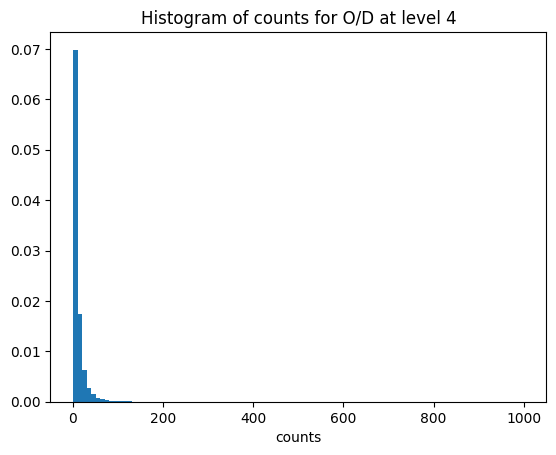

In [36]:
# make historga of count
import matplotlib.pyplot as plt

final_level = Tree.depth
geo_level = int(final_level / 2)
data_true = Tree.get_data_at_level(Tree.depth)
plt.hist(data_true["COUNT"], bins=100, density=True)
plt.title(f"Histogram of counts for O/D at level {geo_level}")
plt.xlabel("counts")
plt.show()

In [37]:
print("Sparsity of the data ", 1 - len(data_true) / (len(Tree.spine.get_nodes(level=geo_level)) ** 2))

Sparsity of the data  0.0


# Mechanism

In [38]:
import argparse
levels: list[tuple] = [(i, i) if i == j else (i, j) for i in range(geo_level + 1) for j in range(i, i + 2) if
                       j < geo_level + 1]

max_error_dense = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_discovery_rate_dense = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_negative_rate_dense = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
MAE = np.zeros((num_mechanisms, 2, len(levels)))
std = np.zeros((num_mechanisms, 2, len(levels)))
TIME = np.zeros((num_mechanisms, len(epsilons), num_experiments))

metrics_nonzero = {"max_error": max_error_dense, "false_discovery_rate": false_discovery_rate_dense,
           "false_negative_rate": false_negative_rate_dense, "MAE": MAE, "std": std, "TIME": TIME}

## Apply Stability Histogram

In [39]:
from mechanism import VanillaSH

args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1)

num_mech = 0
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_nonzero, VanillaSH, args, num_mech, e)

Experiment 10
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 6.20 seconds


100%|██████████| 9/9 [00:01<00:00,  4.87it/s]


## Apply VanillaGauss

In [40]:
from mechanism import VanillaGauss

args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1)

num_mech = 1
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_nonzero, VanillaGauss, args, num_mech, e)

Experiment 10
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 2.64 seconds


100%|██████████| 9/9 [00:01<00:00,  4.79it/s]


## Apply GaussOpt with L_2

In [41]:
from mechanism import GaussOpt

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="standard_int", p=2, split_method='uniform')

num_mech = 2
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_nonzero, GaussOpt, args, num_mech, e)

Experiment 10
Optimizing level 1/8...
Optimizing level 2/8...
Optimizing level 3/8...
Optimizing level 4/8...
Optimizing level 5/8...
Optimizing level 6/8...


/Users/fabrizioboninsegna/miniconda3/envs/top-down/lib/python3.11/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Optimizing level 7/8...
Optimizing level 8/8...
Time taken to create the dataset: 326.95 seconds
Done!


100%|██████████| 9/9 [00:01<00:00,  4.76it/s]


## Apply GaussOpt with L_inf (standard optimizer)

In [42]:
from mechanism import GaussOpt

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="standard_int", p="inf", split_method='uniform')

num_mech = 3
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_nonzero, GaussOpt, args, num_mech, e)

Experiment 10
Optimizing level 1/8...
Optimizing level 2/8...
Optimizing level 3/8...
Optimizing level 4/8...
Optimizing level 5/8...
Optimizing level 6/8...
Optimizing level 7/8...
Optimizing level 8/8...
Time taken to create the dataset: 249.80 seconds
Done!


100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


## Apply GaussOpt with L_inf (IntOpt)

In [43]:
from mechanism import GaussOpt

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="int_opt", p="inf", split_method='uniform')

num_mech = 4
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_nonzero, GaussOpt, args, num_mech, e)

Experiment 10
Optimizing level 1/8...
Optimizing level 2/8...
Optimizing level 3/8...
Optimizing level 4/8...
Optimizing level 5/8...
Optimizing level 6/8...
Optimizing level 7/8...
Optimizing level 8/8...
Time taken to create the dataset: 162.73 seconds
Done!


100%|██████████| 9/9 [00:01<00:00,  7.13it/s]


 ## Maximum Absolute Error per Level

In [44]:
metrics_to_plot = metrics_nonzero
save_to = "../plots/synthetic_random/nonzero/"

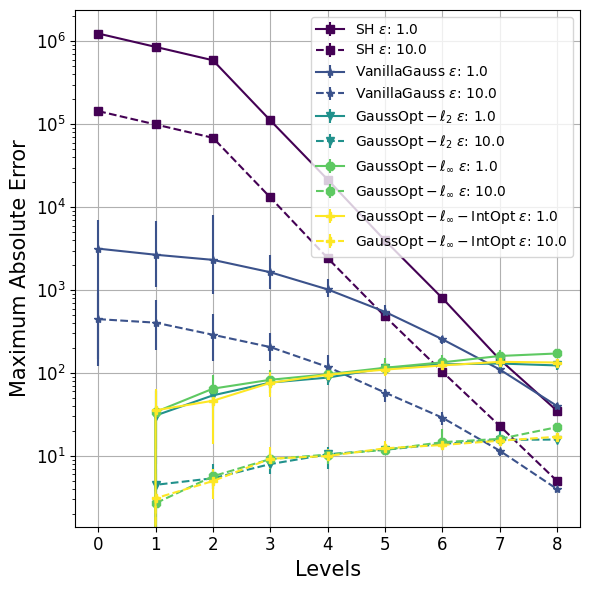

In [45]:
plot(metrics_to_plot["max_error"], y_label="Maximum Absolute Error", log=True, save_to=save_to, name="max_error")

## Mean Absolute Error per Level

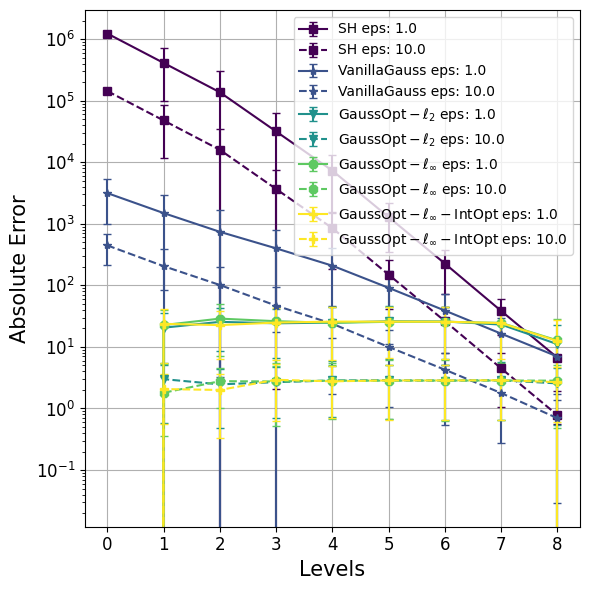

In [46]:
MAE_plot(metrics_to_plot["MAE"], metrics_to_plot["std"], save_to=save_to, name="MAE")

## False Discovery Rate

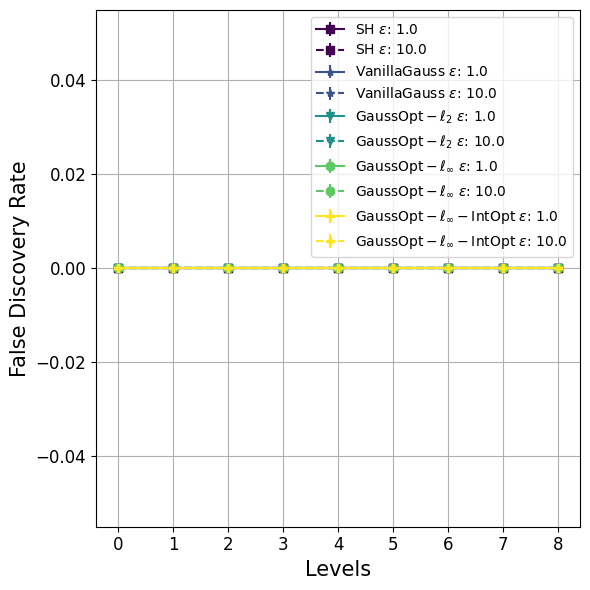

In [47]:
plot(metrics_to_plot["false_discovery_rate"], y_label="False Discovery Rate", log=False, save_to=save_to, name="false_discovery_rate")

## False Negative Rate

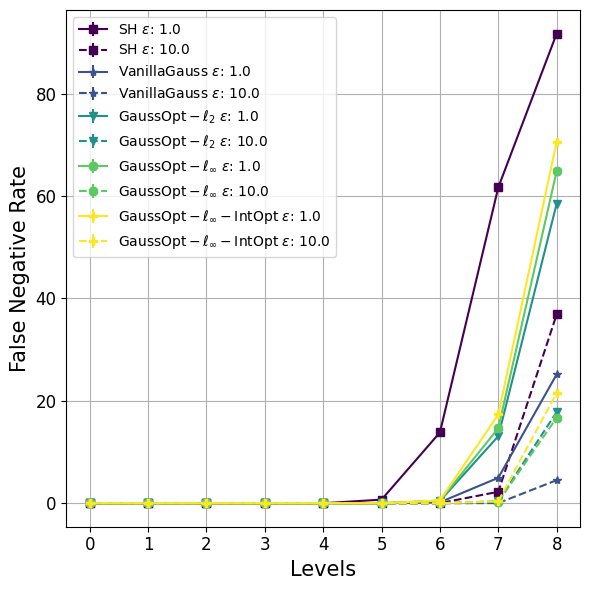

In [48]:
plot(metrics_to_plot["false_negative_rate"], y_label="False Negative Rate", log=False, save_to=save_to, name="false_negative_rate")

## Time

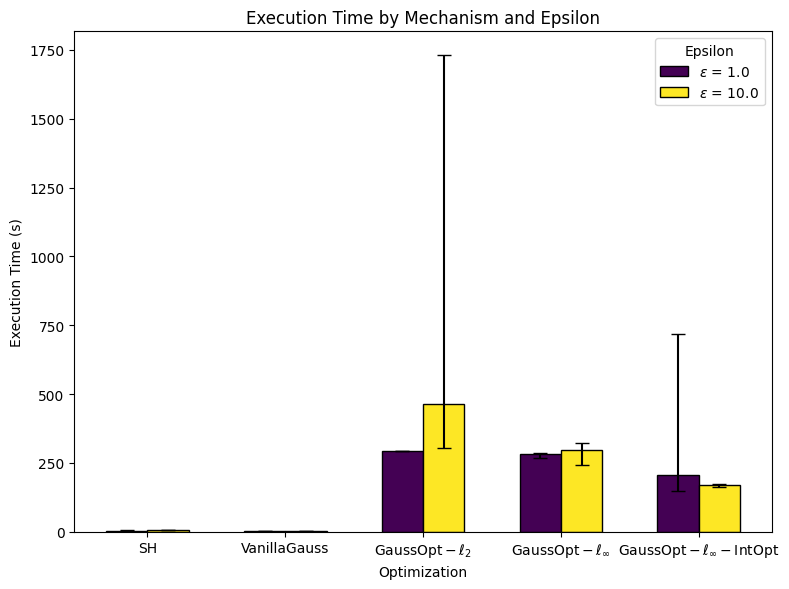

In [49]:
plot_time(metrics_to_plot["TIME"], save_to=save_to, name="time")

In [50]:
# save metrics_to_plot
with open(os.path.join(save_to, "metrics.pickle"), "wb") as f:
    pickle.dump(metrics_to_plot, f)

# Dense dataset

In [67]:
density = "dense"

folder_path = f"../data/synthetic_{type}_branching_{density}/"
with open(os.path.join(folder_path, "structure/geo_spine.pickle"), "rb") as f:
    geo_spine = pickle.load(f)

# upload csv data
df = pd.read_csv(os.path.join(folder_path, "data.csv"))

spine = GeoSpine(geo_spine)
Tree = OD_tree(df, spine)

## Histogram of counts for the finest level

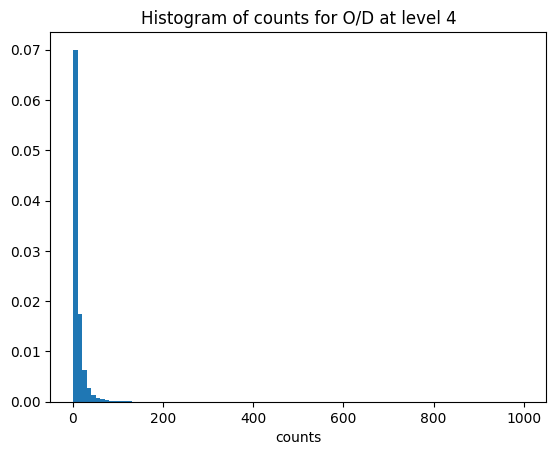

In [68]:
# make historga of count
import matplotlib.pyplot as plt

final_level = Tree.depth
geo_level = int(final_level / 2)
data_true = Tree.get_data_at_level(Tree.depth)
plt.hist(data_true["COUNT"], bins=100, density=True)
plt.title(f"Histogram of counts for O/D at level {geo_level}")
plt.xlabel("counts")
plt.show()

In [69]:
print("Sparsity of the data ", 1 - len(data_true) / (len(Tree.spine.get_nodes(level=geo_level)) ** 2))

Sparsity of the data  0.5000026423569824


# Mechanism

In [70]:
import argparse

levels: list[tuple] = [(i, i) if i == j else (i, j) for i in range(geo_level + 1) for j in range(i, i + 2) if
                       j < geo_level + 1]

# mechanisms, epsilons, experiments, levels
num_mechanisms = 5
max_error = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_discovery_rate = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_negative_rate = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
MAE = np.zeros((num_mechanisms, 2, len(levels)))
std = np.zeros((num_mechanisms, 2, len(levels)))
TIME = np.zeros((num_mechanisms, len(epsilons), num_experiments))

metrics_dense = {"max_error": max_error, "false_discovery_rate": false_discovery_rate,
           "false_negative_rate": false_negative_rate, "MAE": MAE, "std": std, "TIME": TIME}

## Apply Stability Histogram

In [71]:
from mechanism import VanillaSH

args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1)

num_mech = 0
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_dense, VanillaSH, args, num_mech, e)

Experiment 10
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 2.51 seconds


100%|██████████| 9/9 [00:00<00:00, 11.97it/s]


## Apply VanillaGauss

In [72]:
from mechanism import VanillaGauss

args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1)

num_mech = 1
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_dense, VanillaGauss, args, num_mech, e)

Experiment 10
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 2.10 seconds


100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


## Apply GaussOpt with L_2

In [73]:
from mechanism import GaussOpt

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="standard_int", p=2, split_method='uniform')

num_mech = 2
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_dense, GaussOpt, args, num_mech, e)

Experiment 10
Optimizing level 1/8...
Optimizing level 2/8...
Optimizing level 3/8...
Optimizing level 4/8...
Optimizing level 5/8...
Optimizing level 6/8...
Optimizing level 7/8...
Optimizing level 8/8...
Time taken to create the dataset: 180.27 seconds
Done!


100%|██████████| 9/9 [00:01<00:00,  7.96it/s]


## Apply GaussOpt with L_inf (standard optimizer)

In [74]:
from mechanism import GaussOpt

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="standard_int", p="inf", split_method='uniform')

num_mech = 3
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_dense, GaussOpt, args, num_mech, e)

Experiment 10
Optimizing level 1/8...
Optimizing level 2/8...
Optimizing level 3/8...
Optimizing level 4/8...
Optimizing level 5/8...
Optimizing level 6/8...
Optimizing level 7/8...
Optimizing level 8/8...
Time taken to create the dataset: 173.67 seconds
Done!


100%|██████████| 9/9 [00:01<00:00,  8.37it/s]


## Apply GaussOpt with L_inf (IntOpt)

In [75]:
from mechanism import GaussOpt

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="int_opt", p="inf", split_method='uniform')

num_mech = 4
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_dense, GaussOpt, args, num_mech, e)

Experiment 10
Optimizing level 1/8...
Optimizing level 2/8...
Optimizing level 3/8...
Optimizing level 4/8...
Optimizing level 5/8...
Optimizing level 6/8...
Optimizing level 7/8...
Optimizing level 8/8...
Time taken to create the dataset: 104.56 seconds
Done!


100%|██████████| 9/9 [00:01<00:00,  8.95it/s]


 ## Maximum Absolute Error per Level

In [76]:
metrics_to_plot = metrics_dense
save_to = "../plots/synthetic_random/dense/"

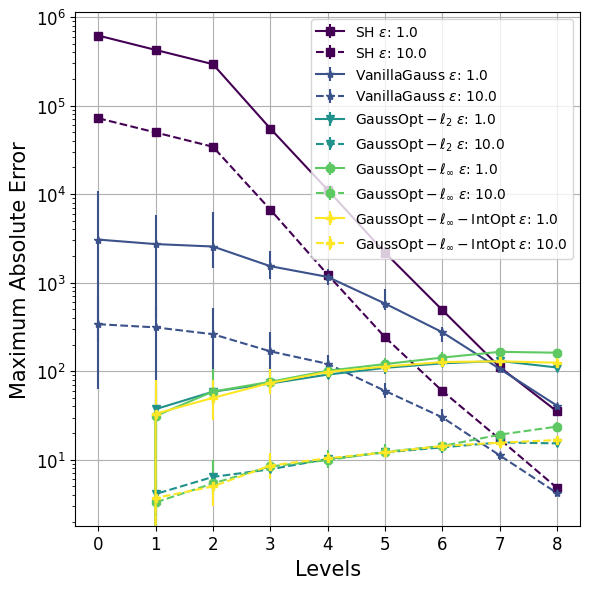

In [77]:
plot(metrics_to_plot["max_error"], y_label="Maximum Absolute Error", log=True, save_to=save_to, name="max_error")

## Mean Absolute Error per Level

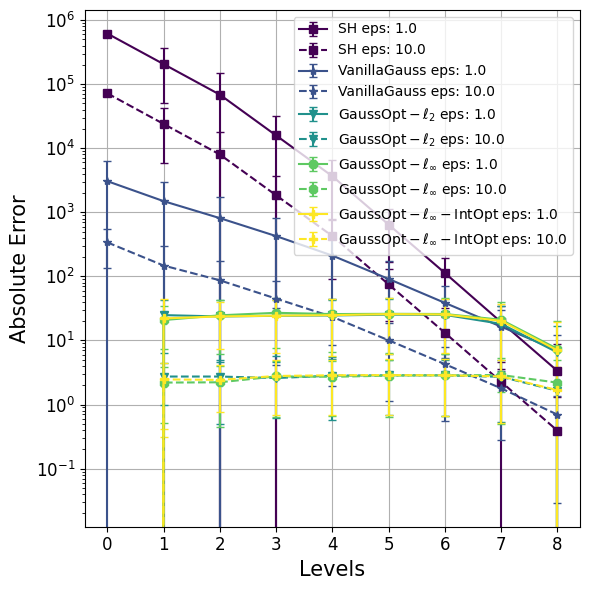

In [78]:
MAE_plot(metrics_to_plot["MAE"], metrics_to_plot["std"], save_to=save_to, name="MAE")

## False Discovery Rate

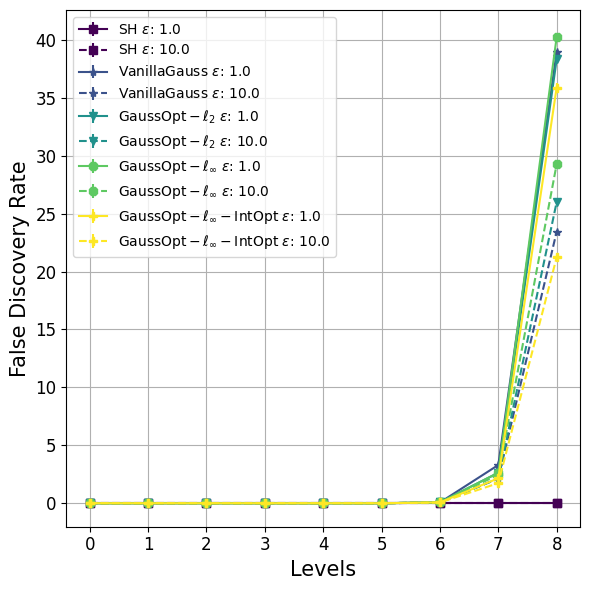

In [79]:
plot(metrics_to_plot["false_discovery_rate"], y_label="False Discovery Rate", log=False, save_to=save_to, name="false_discovery_rate")

## False Negative Rate

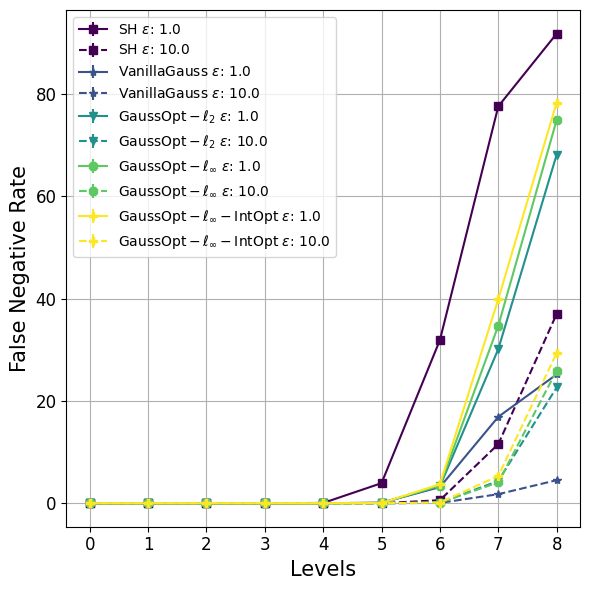

In [80]:
plot(metrics_to_plot["false_negative_rate"], y_label="False Negative Rate", log=False, save_to=save_to, name="false_negative_rate")

## Time

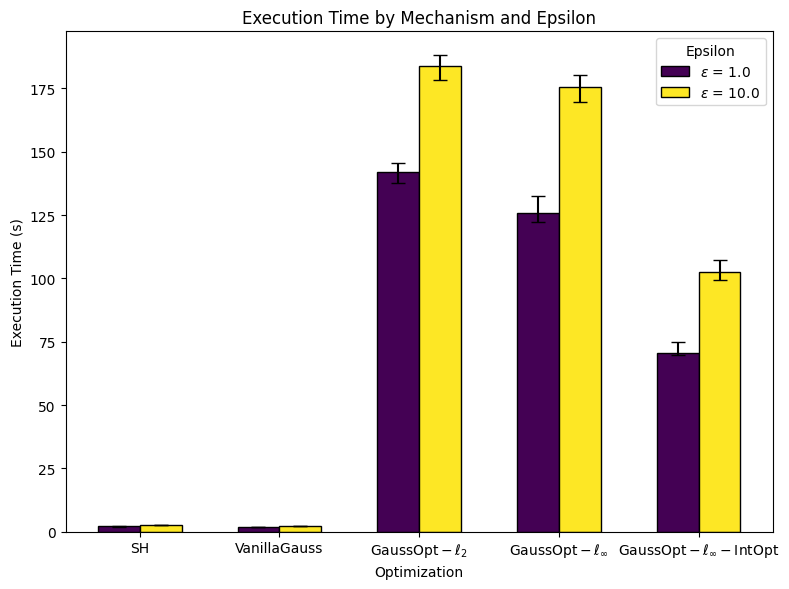

In [81]:
plot_time(metrics_to_plot["TIME"], save_to=save_to, name="time")

In [82]:
# save metrics_to_plot
with open(os.path.join(save_to, "metrics.pickle"), "wb") as f:
    pickle.dump(metrics_to_plot, f)

# Sparse dataset

In [10]:
density = "sparse"

folder_path = f"../data/synthetic_{type}_branching_{density}/"
with open(os.path.join(folder_path, "structure/geo_spine.pickle"), "rb") as f:
    geo_spine = pickle.load(f)

# upload csv data
df = pd.read_csv(os.path.join(folder_path, "data.csv"))

spine = GeoSpine(geo_spine)
Tree = OD_tree(df, spine)

## Histogram of counts for the finest level

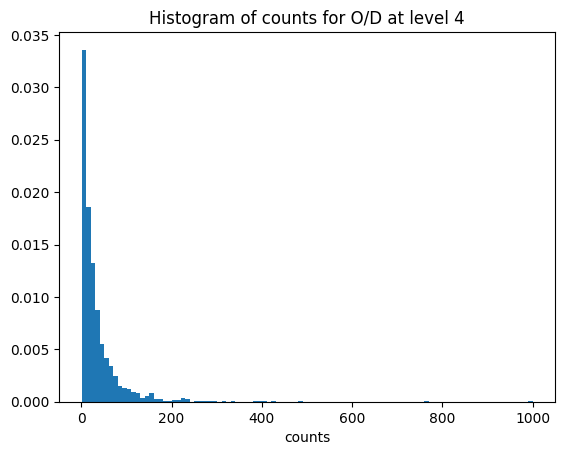

In [11]:
# make historga of count
import matplotlib.pyplot as plt

final_level = Tree.depth
geo_level = int(final_level / 2)
data_true = Tree.get_data_at_level(Tree.depth)
plt.hist(data_true["COUNT"], bins=100, density=True)
plt.title(f"Histogram of counts for O/D at level {geo_level}")
plt.xlabel("counts")
plt.show()

In [12]:
print("Sparsity of the data ", 1 - len(data_true) / (len(Tree.spine.get_nodes(level=geo_level)) ** 2))

Sparsity of the data  0.9900013211784913


# Mechanism

In [13]:
import argparse

levels: list[tuple] = [(i, i) if i == j else (i, j) for i in range(geo_level + 1) for j in range(i, i + 2) if
                       j < geo_level + 1]

# mechanisms, epsilons, experiments, levels
num_mechanisms = 5
max_erroe = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_discovery_rate = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_negative_rate = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
MAE = np.zeros((num_mechanisms, 2, len(levels)))
std = np.zeros((num_mechanisms, 2, len(levels)))
TIME = np.zeros((num_mechanisms, len(epsilons), num_experiments))

metrics_sparse = {"max_error": max_erroe, "false_discovery_rate": false_discovery_rate,
           "false_negative_rate": false_negative_rate, "MAE": MAE, "std": std, "TIME": TIME}

## Apply Stability Histogram

In [14]:
from mechanism import VanillaSH

args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1)

num_mech = 0
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_sparse, VanillaSH, args, num_mech, e)

Experiment 10
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 0.15 seconds


100%|██████████| 9/9 [00:00<00:00, 80.19it/s]


## Apply VanillaGauss

In [15]:
from mechanism import VanillaGauss

args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1)

num_mech = 1
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_sparse, VanillaGauss, args, num_mech, e)

Experiment 10
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 1.99 seconds


100%|██████████| 9/9 [00:01<00:00,  8.41it/s]


## Apply GaussOpt with L_2

In [16]:
from mechanism import GaussOpt

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="standard_int", p=2, split_method='uniform')

num_mech = 2
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_sparse, GaussOpt, args, num_mech, e)

Experiment 10
Optimizing level 1/8...
Optimizing level 2/8...
Optimizing level 3/8...
Optimizing level 4/8...
Optimizing level 5/8...
Optimizing level 6/8...
Optimizing level 7/8...
Optimizing level 8/8...
Time taken to create the dataset: 22.39 seconds
Done!


100%|██████████| 9/9 [00:00<00:00, 54.48it/s]


## Apply GaussOpt with L_inf (standard optimizer)

In [17]:
from mechanism import GaussOpt

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="standard_int", p="inf", split_method='uniform')

num_mech = 3
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_sparse, GaussOpt, args, num_mech, e)

Experiment 10
Optimizing level 1/8...
Optimizing level 2/8...
Optimizing level 3/8...
Optimizing level 4/8...
Optimizing level 5/8...
Optimizing level 6/8...
Optimizing level 7/8...
Optimizing level 8/8...
Time taken to create the dataset: 22.34 seconds
Done!


100%|██████████| 9/9 [00:00<00:00, 57.34it/s]


## Apply GaussOpt with L_inf (IntOpt)

In [18]:
from mechanism import GaussOpt

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="int_opt", p="inf", split_method='uniform')

num_mech = 4
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(Tree, metrics_sparse, GaussOpt, args, num_mech, e)

Experiment 10
Optimizing level 1/8...
Optimizing level 2/8...
Optimizing level 3/8...
Optimizing level 4/8...
Optimizing level 5/8...
Optimizing level 6/8...
Optimizing level 7/8...
Optimizing level 8/8...
Time taken to create the dataset: 6.28 seconds
Done!


100%|██████████| 9/9 [00:00<00:00, 60.96it/s]


 ## Maximum Absolute Error per Level

In [19]:
metrics_to_plot = metrics_sparse
save_to = "../plots/synthetic_random/sparse/"

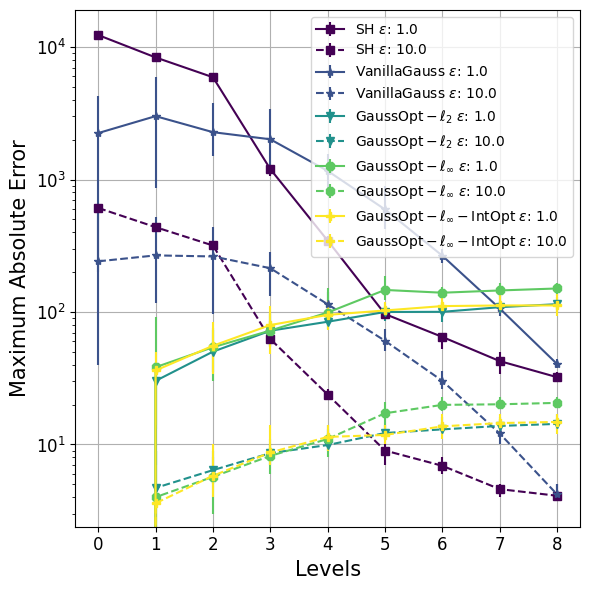

In [20]:
plot(metrics_to_plot["max_error"], y_label="Maximum Absolute Error", log=True, save_to=save_to, name="max_error")

## Mean Absolute Error per Level

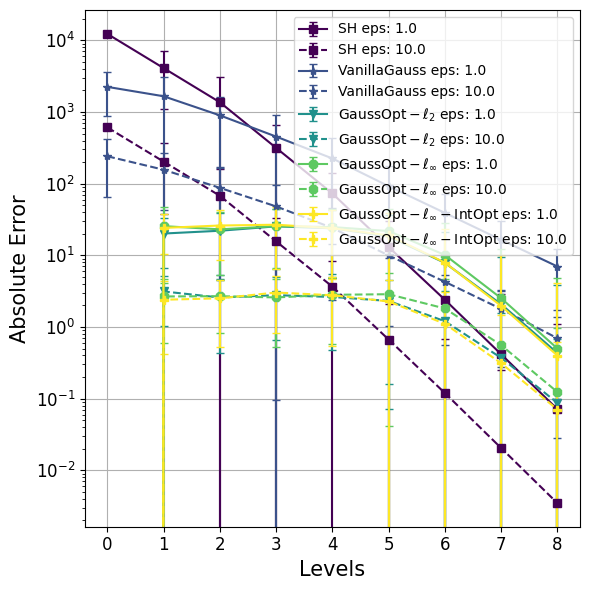

In [21]:
MAE_plot(metrics_to_plot["MAE"], metrics_to_plot["std"], save_to=save_to, name="MAE")

## False Discovery Rate

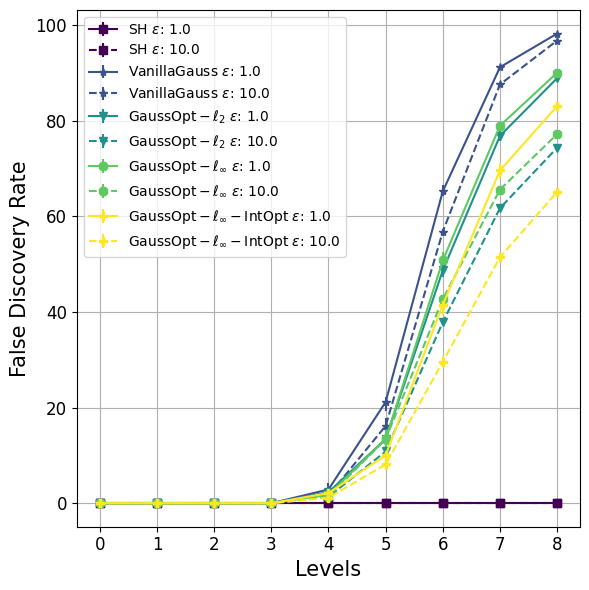

In [22]:
plot(metrics_to_plot["false_discovery_rate"], y_label="False Discovery Rate", log=False, save_to=save_to, name="false_discovery_rate")

## False Negative Rate

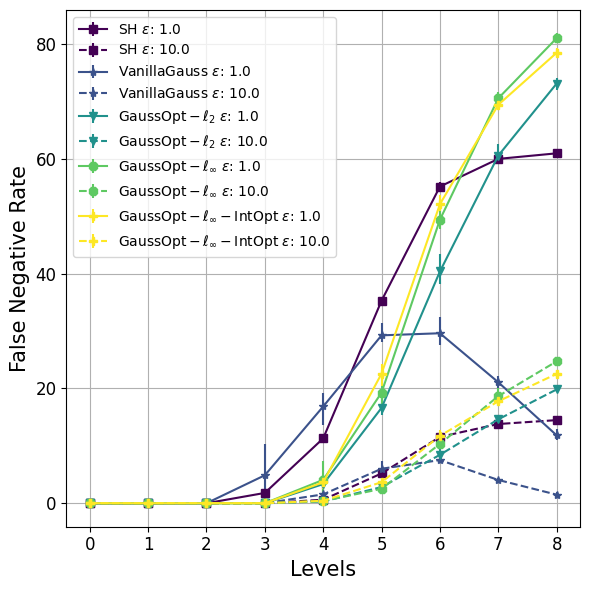

In [23]:
plot(metrics_to_plot["false_negative_rate"], y_label="False Negative Rate", log=False, save_to=save_to, name="false_negative_rate")

## Time

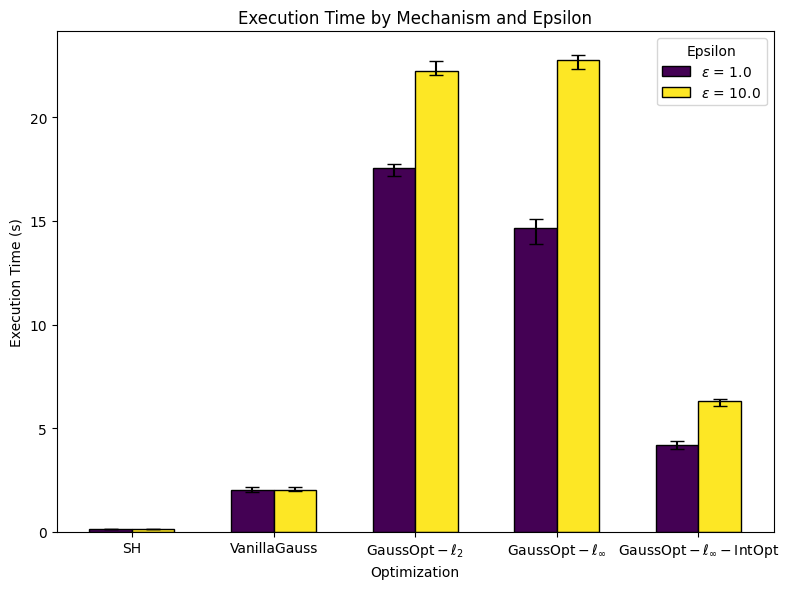

In [24]:
plot_time(metrics_to_plot["TIME"], save_to=save_to, name="time")

In [25]:
# save metrics_to_plot
with open(os.path.join(save_to, "metrics.pickle"), "wb") as f:
    pickle.dump(metrics_to_plot, f)